# Ciclope example 03 - Compression test of embedded human tooth

Created on:  30.04.2022 <br />
Last update: 27.07.2022 <br />

---
The example implements the following ciclope pipeline:
- [X] Load and inspect microCT volume data of human tooth
- [X] Image preprocessing
    - [x] Segment different tissue types (enamel, dentin)
    - [X] Map different scalars to the 3D image to represent different tissues
    - [X] Add embedding material (dental cement) with given Grey Value
    - [X] Add end-caps (steel) with given Grey Value
- [x] Generate 3D Unstructured Grid mesh of tetrahedra
- [x] Generate tetrahedra-FE model for simulation in CalculX or Abaqus from 3D Unstructured Grid mesh 
    - [x] Linear, static analysis definition: displacement-driven uniaxial compression test
    - [X] Material mapping (assign one material card to each dataset grey value)
- [x] Launch simulation in Calculix. For info on the solver visit the [Calculix homepage](http://www.calculix.de/)
- [x] Convert Calculix output to .VTK for visualization in Paraview
- [ ] Automatic plot of displacement field mid-planes through the model

Type `python ciclope.py -h` to display the ciclope help with a full list of available command line arguments.

## Configuration

In [2]:
import sys
sys.path.append('./../')

In [29]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import mcubes
from scipy import ndimage, misc
from skimage.filters import threshold_otsu, threshold_multiotsu, gaussian
from skimage import morphology
import skimage.io as skio

from ciclope.utils.recon_utils import plot_midplanes, bbox
from ciclope.utils.preprocess import fill_voids, embed, add_cap
from ciclope import tetraFE

matplotlib.rcParams['figure.dpi'] = 200

font = {'weight' : 'normal',
        'size'   : 8}

plt.rc('font', **font)

#### Load input data

In [3]:
input_file = './../test_data/tooth/Tooth_TAU_3_scaled_2.tif' # scale factor: 0.4

In [4]:
data_3D = skio.imread(input_file, plugin="tifffile")
vs = np.ones(3)*16.5e-3/0.4 # [mm]

Inspect the dataset

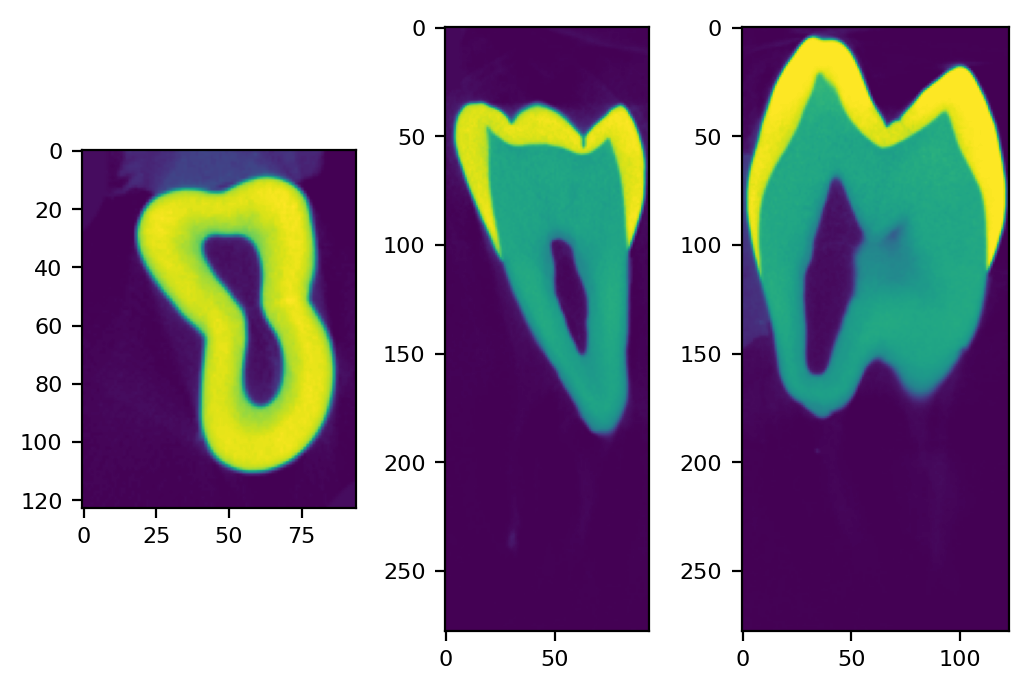

In [10]:
plot_midplanes(data_3D)

Inspect the dataset with [itkwidgets](https://github.com/InsightSoftwareConsortium/itkwidgets)

In [7]:
# import itk
# from itkwidgets import view
# viewer = view(data_3D, ui_collapsed=True)
# viewer.interpolation = False

In [8]:
# # launch itk viewer
# viewer

## Pre-processing
### Thresholding
Find multiple Otsu's thresholds

In [15]:
Ts = threshold_multiotsu(data_3D)
print("Thresholds: {}".format(Ts))

Thresholds: [ 73 193]


Plot the dataset histogram

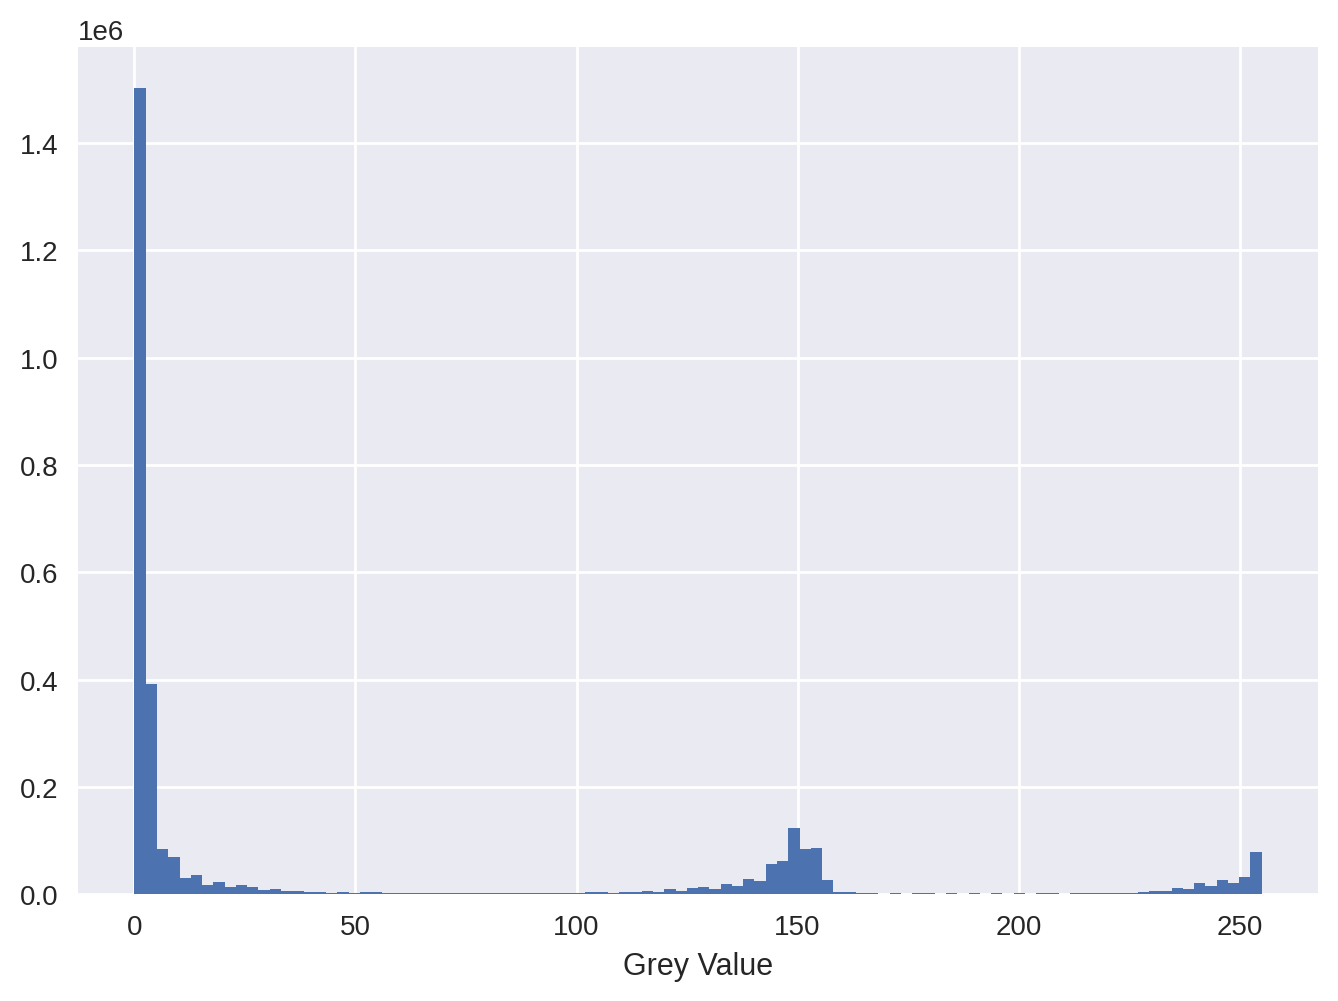

In [30]:
# plot the input image histogram
fig2, ax2 = plt.subplots()
plt.hist(data_3D.ravel(), bins=100)
plt.xlabel('Grey Value')
plt.show()
plt.style.use('seaborn')

### Apply the thresholds:
Separate the whole tooth volume, dentin and enamel areas

In [16]:
BW_tooth = data_3D >= Ts[0]

In [17]:
BW_dentin = (data_3D <= Ts[1]) & (data_3D >= Ts[0])

In [18]:
BW_enamel = data_3D > Ts[1]

### Morphological cleaning of the masks:
Opply morphological open and fill holes within the dentin mask

In [19]:
BW_dentin = ndimage.binary_fill_holes(ndimage.binary_opening(BW_dentin, morphology.ball(3)))

In [20]:
BW_tooth = ndimage.binary_fill_holes(ndimage.binary_opening(BW_tooth, morphology.ball(3)))

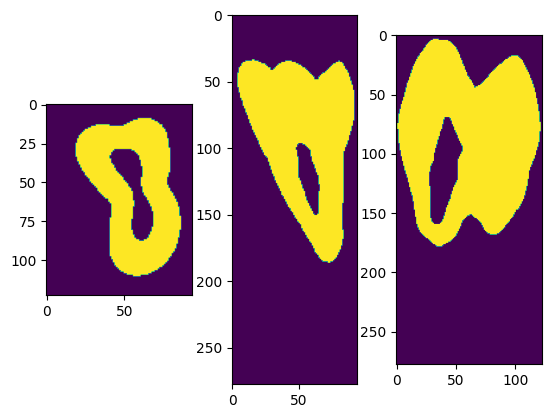

In [35]:
plt.style.use('default')
plot_midplanes(BW_tooth)

# Create color image with different materials
Our goal is to create a 3D image of the tooth + embedding and assign the following scalars to the different materials:
1. dentin
2. enamel
3. cement embedding
4. steel caps

We start by creating an image of the tooth where dentin and enamel have different Grey Values (1 and 2, respectively)

In [24]:
data_for_meshing = fill_voids(BW_dentin*1 + BW_enamel*2, 1, False)

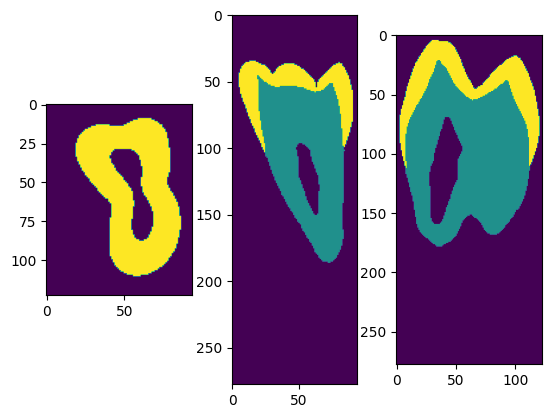

In [25]:
plot_midplanes(data_for_meshing)

## Embed tooth from top and bottom
Add embedding material (cement) from the bottom and top along the image Z-axis. The method `ciclope.utils.preprocess.embed` allows to embed a 3D image from a chosen direction and to specify the Grey Value of the embedding material. For a full list of embedding parameters see the method help typing:  

In [26]:
help(embed)

Help on function embed in module ciclope.utils.preprocess:

embed(I, embed_depth, embed_dir, embed_val=None, pad=0, makecopy=False)
    Add embedding to 3D image.
    Direction and depth of the embedded region should be given. Zeroes in the input image is considered to be background.
    
    Parameters
    ----------
    I
        3D data. Zeroes as background.
    embed_depth : int
        Embedding depth in pixels.
    embed_dir : str
        Embedding direction. Can be "-x", "+x", "-y", "+y", "-z", or "+z".
    embed_val : float
        Embedding grey value.
    pad = int
        Padding around bounding box of embedded area.
    makecopy : bool
        Make copy of the input image.
    
    Returns
    ----------
    I
        Embedded image. Same size as the input one.
    BW_embedding
        BW mask of the embedding area.



Embed from the bottom along the X-axis over 140 image voxels. Assign `Grey Value = 3` to the embedding material:

In [32]:
data_for_meshing_embedded, BW_embedding_bottom = embed(data_for_meshing, 140, "-z", embed_val=3, pad=2, makecopy=True)

Embed from the top along the X-axis over 40 image voxels. Assign `Grey Value = 3` to the embedding material:

In [33]:
data_for_meshing_embedded, BW_embedding_top = embed(data_for_meshing_embedded, 40, "+z", embed_val=3, pad=2)

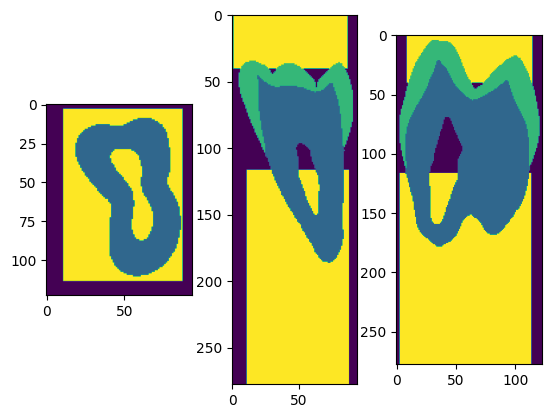

In [36]:
plot_midplanes(data_for_meshing_embedded)

## Add steel caps
The method `ciclope.utils.preprocess.add_cap` allows to add caps to a 3D image from a chosen direction, with a given thickness and Grey Value.

To see the method help type `help(ciclope.utils.preprocess.add_cap`

Add 5-voxels-thick caps with `GV=4`:

In [38]:
data_for_meshing_embedded = add_cap(data_for_meshing_embedded, cap_thickness=5, cap_val=4)

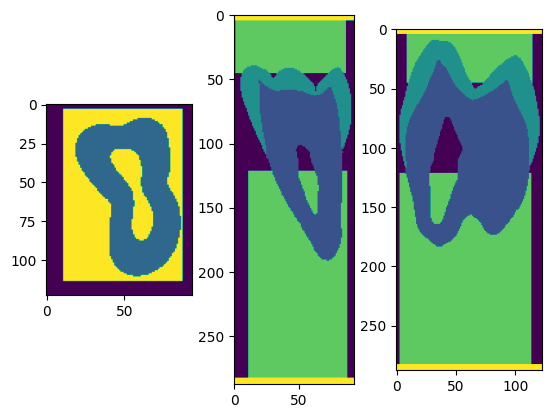

In [39]:
plot_midplanes(data_for_meshing_embedded)

# Create tetrahedra mesh
Volume meshing using [CGAL](https://www.cgal.org/) through [pygalmesh](https://github.com/nschloe/pygalmesh)

In [40]:
filename_mesh_out = './../test_data/tooth/results/Tooth_3_scaled_2.vtk'

In [ ]:
mesh = tetraFE.cgal_mesh(data_for_meshing_embedded, vs, 'tetra', 1.2 * min(vs), 3.6 * min(vs))

![Tooth polychrome tetrahedra mesh](./../test_data/tooth/results/Tooth_3_scaled_2_materials2.png)

## Write Abaqus input FE files
### Generate tetrahedra-FE model with constant material properties
The method `ciclope.tetraFE.mesh2tetrafe` assumes that the material property definition is contained in the FE analysis `.INP` template file.

In [3]:
input_template = "./../input_templates/tmp_example03_comp_static_tooth.inp"

Inspect input template file:
- The first section of the input template contains material definitions for the four materials of the model
- The next section defines a static linear-step analysis with the following boundary conditions:
    - Displacement along Z = 0 for all nodes on the model top surface (NODES_Z1)
    - Displacement completely fixed (X=0, Y=0, Z=0) for the nodes at the (0,0,0) corner. This is to avoid free-body motion
    - 0.25 mm displacement imposed along Z on all nodes on the bottom surface (NODES_Z0)

In [14]:
!cat {input_template} # on linux

** User material property definition:
** ---------------------------------------------------
** DENTIN - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3924884/
** ---------------------------------------------------
*SOLID SECTION, ELSET=SET1, MATERIAL=DENTIN
1.
*MATERIAL,NAME=DENTIN
*ELASTIC
1653.7, 0.3
** ---------------------------------------------------
** ENAMEL
** ---------------------------------------------------
*SOLID SECTION, ELSET=SET2, MATERIAL=ENAMEL
1.
*MATERIAL,NAME=ENAMEL
*ELASTIC
1338.2, 0.3
** ---------------------------------------------------
** CEMENT H poly - https://brieflands.com/articles/zjrms-94390.html
** ---------------------------------------------------
*SOLID SECTION, ELSET=SET3, MATERIAL=CEMENT
1.
*MATERIAL,NAME=CEMENT
*ELASTIC
2200., 0.3
** ---------------------------------------------------
** STEEL
** ---------------------------------------------------
*SOLID SECTION, ELSET=SET4, MATERIAL=STEEL
1.
*MATERIAL,NAME=STEEL
*ELASTIC
210000., 0.333
** ------

In [8]:
filename_out = './../test_data/tooth/results/Tooth_3_scaled_2.inp'

Generate CalculiX FE input file

In [ ]:
tetraFE.mesh2tetrafe(mesh, input_template, filename_out, keywords=['NSET', 'ELSET'])

## Solve FE model in calculix
The following section assumes that you have the Calculix solver installed and accessible with the command `ccx_2.17` or for multithread option `ccx_2.17_MT`. <br />
The multithread option in CalculiX is activated by defining the number of threads (default=1) used for the calculation.<br />
This is done by setting the env variable *OMP_NUM_THREADS* with:
`export OMP_NUM_THREADS=8`

In [15]:
!export OMP_NUM_THREADS=8; ccx_2.17_MT "./../test_data/tooth/results/Tooth_3_scaled_2"


************************************************************

CalculiX Version 2.17, Copyright(C) 1998-2020 Guido Dhondt
CalculiX comes with ABSOLUTELY NO WARRANTY. This is free
software, and you are welcome to redistribute it under
certain conditions, see gpl.htm

************************************************************

You are using an executable made on Sun 10 Jan 2021 11:34:19 AM CET

  The numbers below are estimated upper bounds

  number of:

   nodes:        43539
   elements:       239463
   one-dimensional elements:            0
   two-dimensional elements:            0
   integration points per element:            1
   degrees of freedom per node:            3
   layers per element:            1

   distributed facial loads:            0
   distributed volumetric loads:            0
   concentrated loads:            0
   single point constraints:         1668
   multiple point constraints:            1
   terms in all multiple point constraints:            1
   tie con

### Convert Calculix output to Paraview
The following sections assume that you have **ccx2paraview** and **Paraview** installed and working.<br /> For more info visit: <br />
https://www.paraview.org/ <br />
https://github.com/calculix/ccx2paraview

In [6]:
import os
import ccx2paraview

In [9]:
filename_out_base, ext_out = os.path.splitext(filename_out)

In [16]:
ccx2paraview.Converter(filename_out_base + '.frd', ['vtk']).run()

#### Visualize results in Paraview
- Max. Z-displacement: 0.5 mm
- Max. Von Mises stress: 150 MPa

In [28]:
!paraview {filename_out_base + '.vtk'}

![Tooth_UD3_Smises](./../test_data/tooth/results/Tooth_TAU_3_scaled_2_UD3_Smises.png)

#### Post-process FE analysis results
Display the CalculiX FE output `.DAT` file:

In [17]:
filename_dat = filename_out_base + '.dat'

In [18]:
!cat {filename_dat}


 total force (fx,fy,fz) for set NODES_Z0 and time  0.1000000E+01

        5.069543E-10  4.957852E-10  2.068063E+03


- The total reaction force along Z reaches **2068 N**

---
# Embedding from bottom explained
1. Get max X-Y-projection until desired depth

In [42]:
embed_depth = 380 # [pixels]

In [43]:
embed_axis = "z"
embed_dir = -1

In [44]:
BW_dentin.shape

(695, 308, 236)

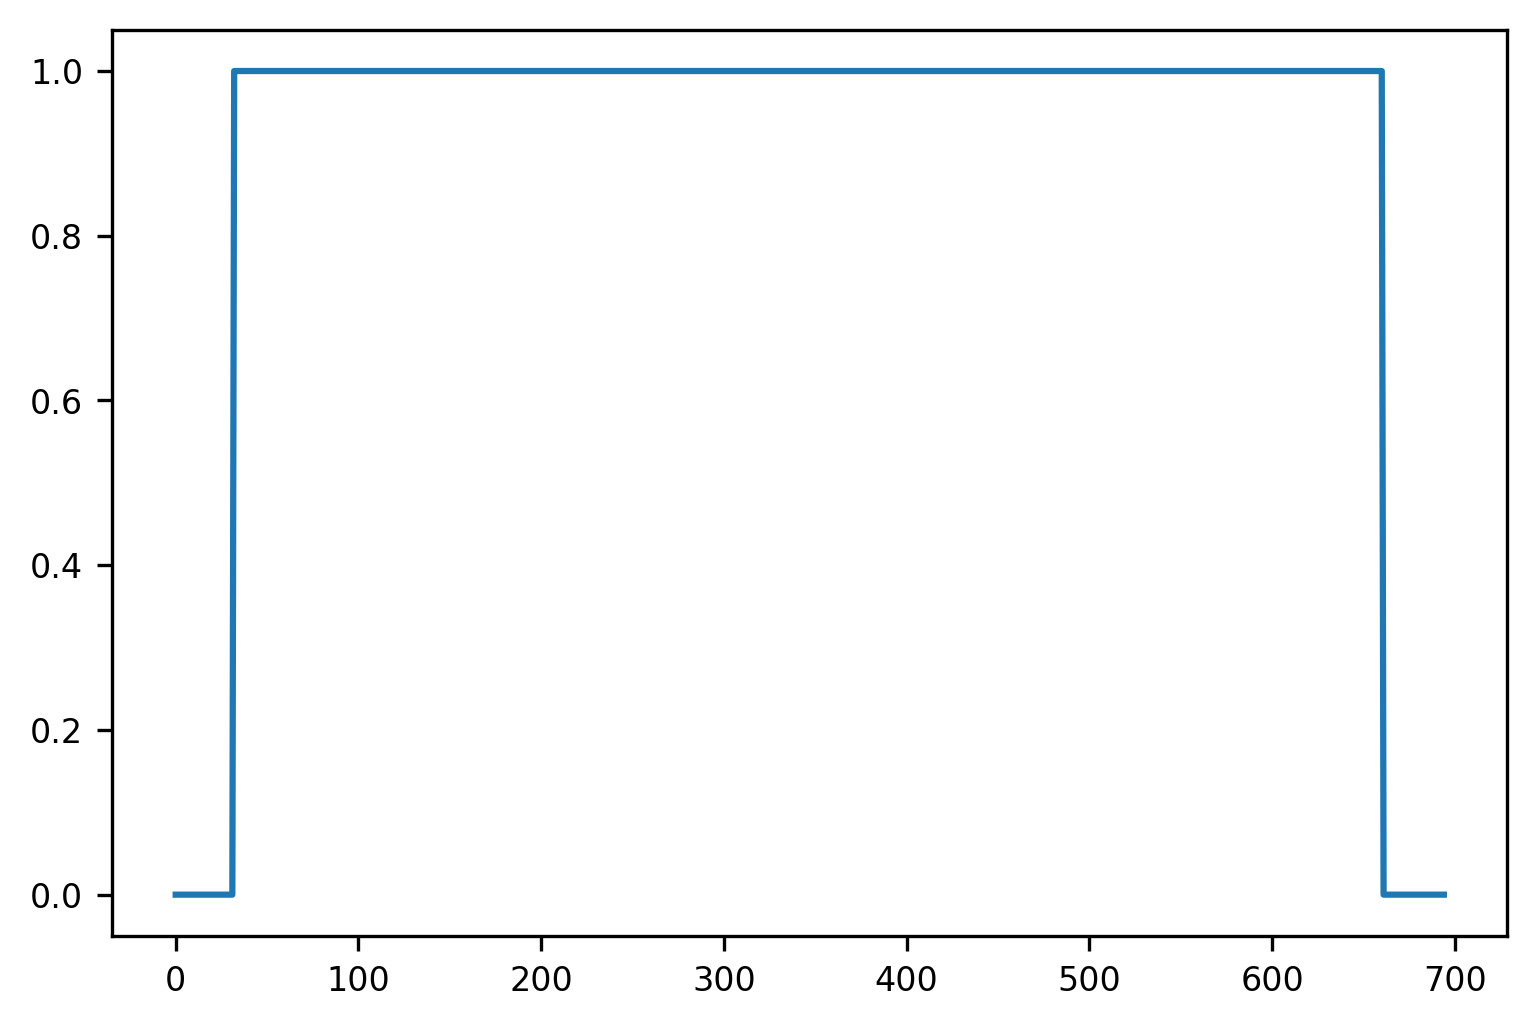

In [46]:
plt.plot(np.max(BW_dentin.max(1), 1))

2. The embeddign start point will be the first Z-value at which the X-Y-projection is nonzero

In [47]:
embed_start = np.where(np.max(BW_dentin.max(1), 1) == True)[-1][-1]

### Get bounding box for embedding
3. Z-max-projection of embedded region

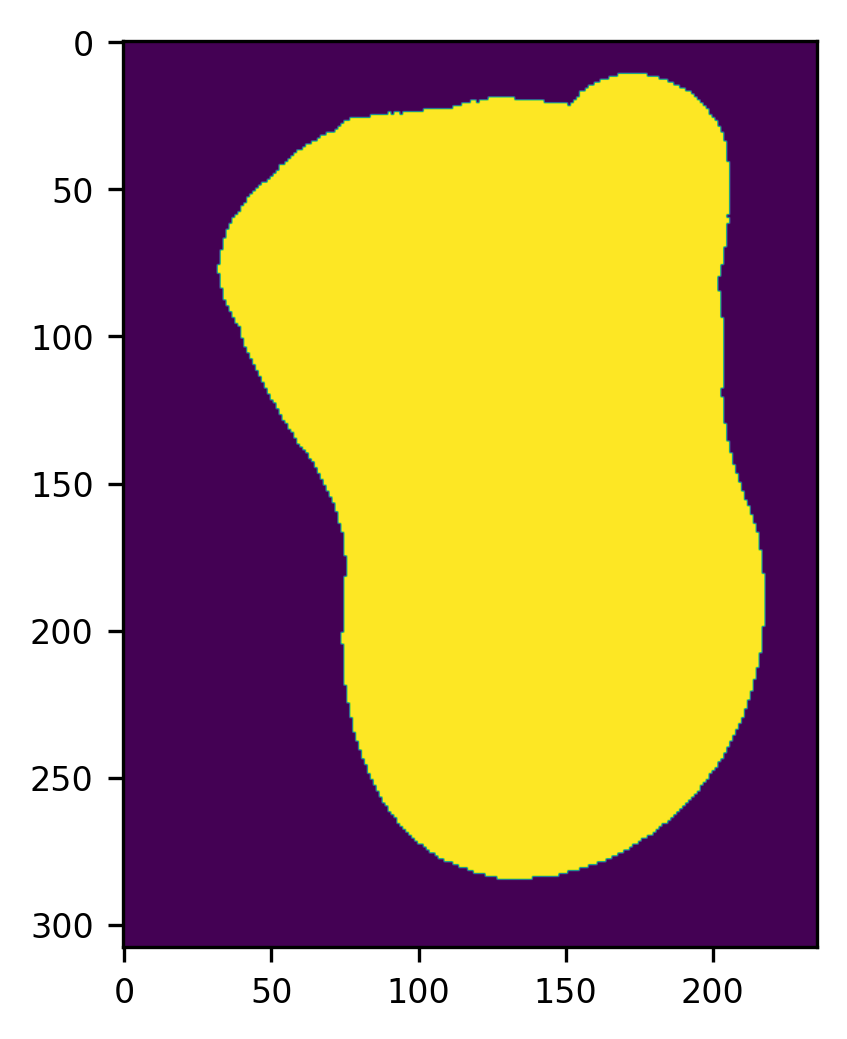

In [49]:
plt.imshow(BW_dentin[embed_start + (embed_dir*embed_depth):,:,:].max(0))

4. Calculate bounding box from the projection using the method `ciclope.utils.recon_utils.bbox`

In [52]:
bbox_origin, bbox_size = bbox(BW_dentin[embed_start + (embed_dir*embed_depth):,:,:])

In [64]:
BW_embedding = np.ma.array(data_3D, mask=False)

In [54]:
BW_embedding.shape

(695, 308, 236)

In [65]:
BW_embedding[embed_start + (embed_dir*embed_depth):, bbox_origin[0]:bbox_origin[0]+bbox_size[0], bbox_origin[1]:bbox_origin[1]+bbox_size[1]] = np.ma.masked

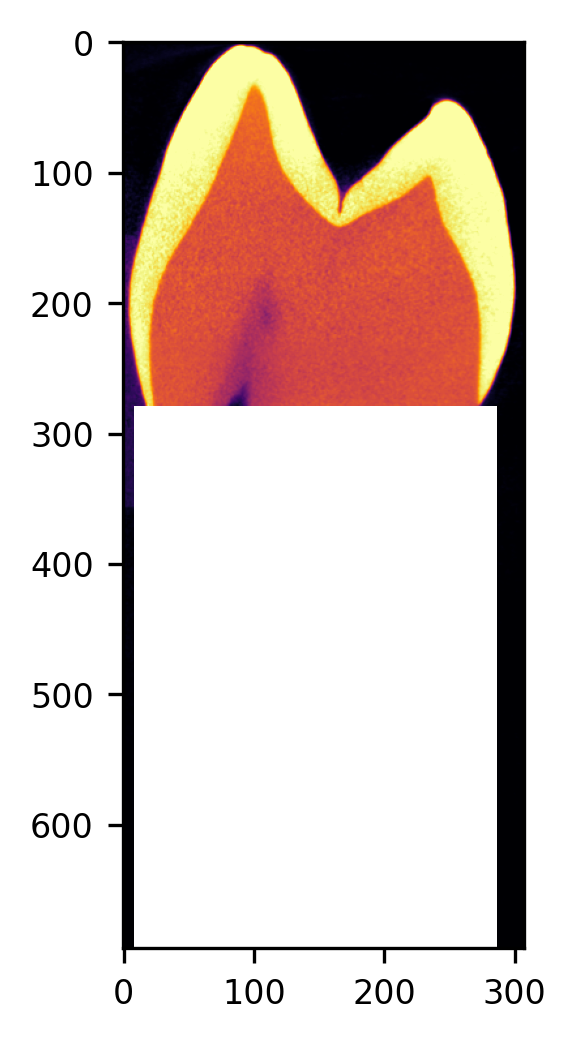

In [66]:
plt.imshow(BW_embedding[:,:,100], cmap='inferno')

5. Remove unconnected stuff to get a mask of the embedding material alone

In [62]:
from preprocess import remove_unconnected

In [67]:
BW_embedding = remove_unconnected(BW_embedding.mask & ~BW_tooth)

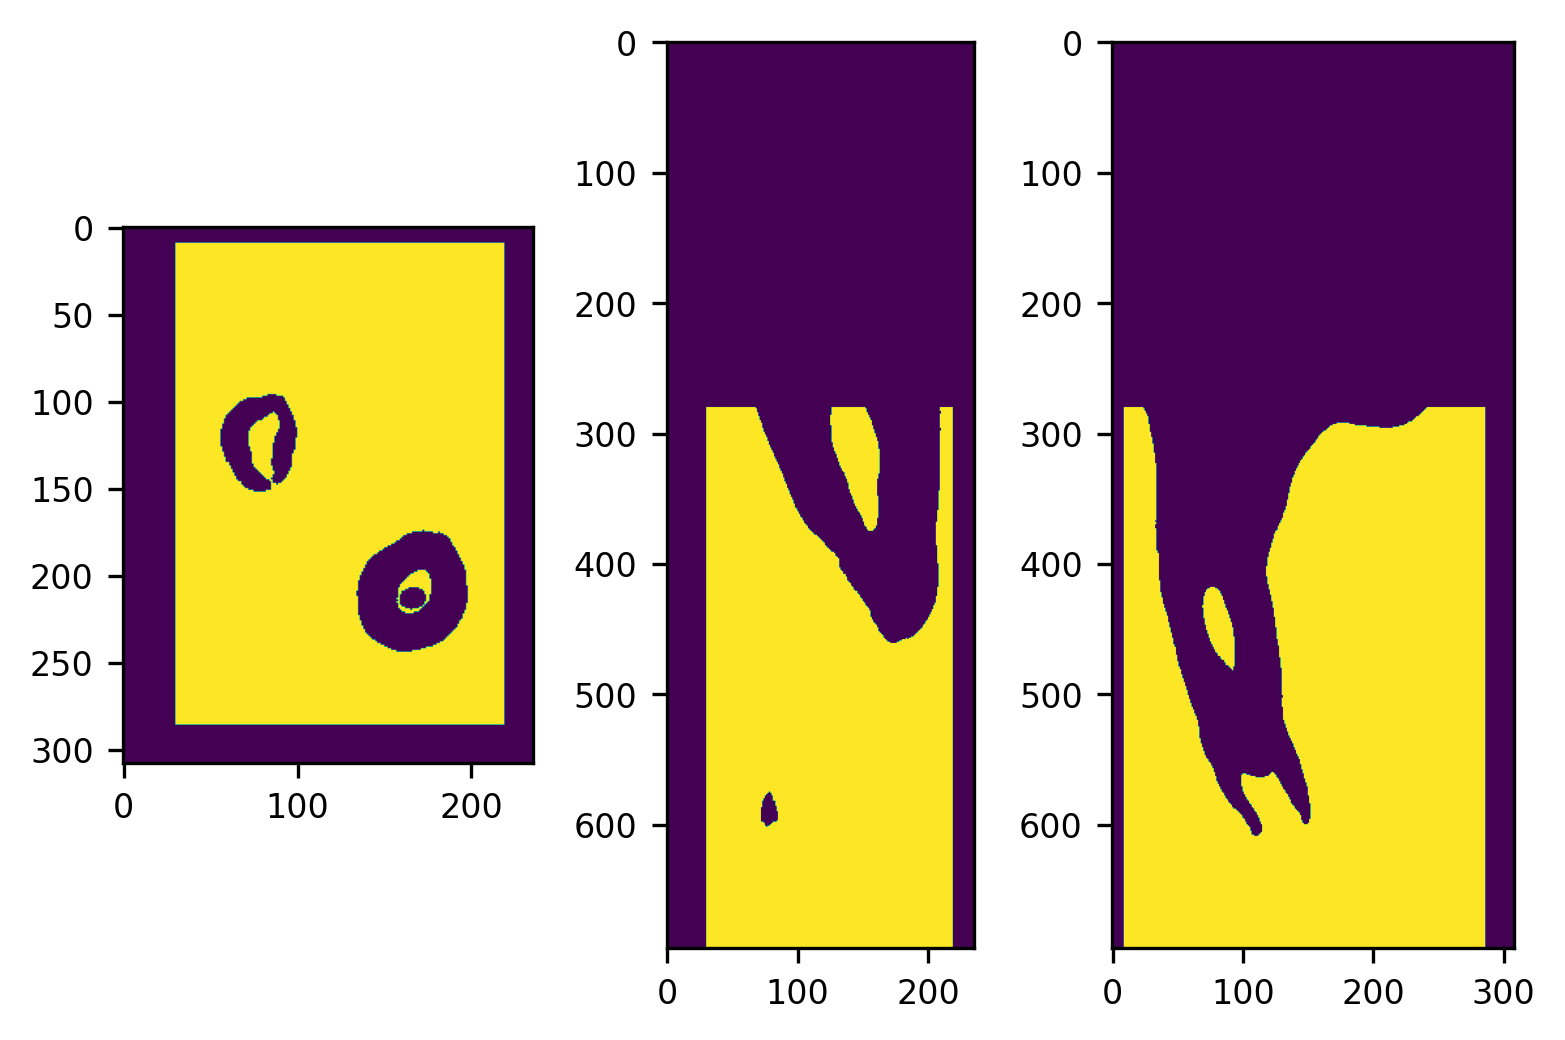

In [75]:
plot_midplanes(BW_embedding, 150, 80, 590)